# John McNulty
# JRM4AG

## First we pull in the data and standardize it

# __Note that we will need to exclude non-english and add sarai formality score__

In [1]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

from sklearn.model_selection import train_test_split
import random

In [2]:
text_data = pd.read_csv("FinalFeatures_Apr10.csv")

In [3]:
# text_data = pd.read_csv("GWBFATCAT_with_initial_features_Mar22.csv")
# text_data.head()

In [4]:
text_data.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
html_file                 object
source                    object
research                   int64
filename                  object
url                       object
Text                      object
lang_langdetect_multi     object
word_count                 int64
question_mark            float64
exclamation_point        float64
structure_count            int64
format_count               int64
context_count              int64
pronoun_count              int64
has_edu_suffix             int64
formality                float64
has_meta_title           float64
has_meta_abstract        float64
dtype: object

In [5]:
# chd_data["famhist"] = (chd_data["famhist"] == "Present")*1 # converts the famhit to 0 (no hist) and 1 (has hist)
#df = df.drop(["famhist"], axis=1)
text_data.head()

,Unnamed: 0,Unnamed: 0.1,html_file,source,research,filename,url,Text,lang_langdetect_multi,word_count,question_mark,exclamation_point,structure_count,format_count,context_count,pronoun_count,has_edu_suffix,formality,has_meta_title,has_meta_abstract
0,0,0,/sfs/lustre/bahamut/scratch/ml8vp/internet_arc...,GWB,0,BSDFSDJFOL4CPAW7YUQL24UMHLZ43INO,https://www.cretalive.gr/kriti/protaseis-gia-p...,Προτάσεις για το πρόβλημα απορρόφησης των παρα...,el,618,0.000000,0.004854,0,0,0,0,0,NaN,1.0,1.0
1,1,1,/sfs/lustre/bahamut/scratch/ml8vp/internet_arc...,GWB,0,VA2DFA5VRG5W7CNVRJQKTRLPWQ6KLQHM,https://journeymagazineptbo.com/category/uncat...,Uncategorized – JOURNEY Magazine JOURNEY Magaz...,en,637,0.012559,0.001570,0,1,0,2,0,0.802178,1.0,0.0
2,2,2,/sfs/lustre/bahamut/scratch/ml8vp/internet_arc...,GWB,0,C764E7NTYBVCAYDGXJ3DLO3RXA3PU4HC,http://www.mylotanswers.com/w/keywords/6/autho...,myLot Discussions - authors - 6 sign in • sign...,en,677,0.017725,0.002954,9,1,2,13,0,0.642857,0.0,0.0
3,3,3,/sfs/lustre/bahamut/scratch/ml8vp/internet_arc...,GWB,0,VEYJ6UFXF3CDVLVZBJOVZHGEIVN2DKN7,http://aaaspaceart.blog.dada.net/post/12069431...,* HOW DO YOU LIKE MY PROFILE PAGE ?? - AAASP...,en,433,0.011547,0.050808,0,0,0,18,0,0.821918,0.0,0.0
4,4,4,/sfs/lustre/bahamut/scratch/ml8vp/internet_arc...,GWB,0,HLLWVPVBNE2BVXWMEHJKDHQXCZJSISGT,http://mastersallen.co.uk/about/,About - Masters Allen Skip to the content Work...,en,546,0.000000,0.000000,3,0,4,4,0,0.682879,1.0,1.0


# Impute Fromality Score

In [6]:
# impute formality score
text_data[['source', 'formality']].groupby(['source']).agg(['mean'])

,formality
,mean
source,
FATCAT,0.843645
GWB,0.846686


In [7]:
text_dataFATCATNA = text_data[text_data["source"] == "FATCAT"]
text_dataFATCATNA = text_dataFATCATNA.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
print("Length of FATCAT without NA is "+str(len(text_dataFATCATNA)))
print("and the average formality score is " + str(text_dataFATCATNA["formality"].mean()))
fatacat_formalityMean = text_dataFATCATNA["formality"].mean()
text_dataGWB = text_data[text_data["source"] == "GWB"]
text_dataGWB = text_dataGWB.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
print("Length of GWB without NA is "+str(len(text_dataGWB)))
print("and the average formality score is " + str(text_dataGWB["formality"].mean()))
gwb_formalityMean = text_dataGWB["formality"].mean()

Length of FATCAT without NA is 8065
and the average formality score is 0.8436388283266211
Length of GWB without NA is 8092
and the average formality score is 0.8466858203510071


In [8]:
text_data.loc[(text_data['formality'].isnull()) & (text_data['source']== "FATCAT"), "formality"] = fatacat_formalityMean
text_data.loc[(text_data['formality'].isnull()) & (text_data['source']== "GWB"), "formality"] = gwb_formalityMean

# Handling meta tag missing values

In [9]:
text_data[text_data["has_meta_title"].isnull()]

,Unnamed: 0,Unnamed: 0.1,html_file,source,research,filename,url,Text,lang_langdetect_multi,word_count,question_mark,exclamation_point,structure_count,format_count,context_count,pronoun_count,has_edu_suffix,formality,has_meta_title,has_meta_abstract
16985,16985,7105,/sfs/lustre/bahamut/scratch/ml8vp/internet_arc...,FATCAT,1,e9e3ac5154ba21c86d21d6eb2b5581ccfbed662e,http://arjournals.com/index.php/Biol/article/v...,Understanding evolutionary paradigm of knockdo...,en,14846,0.000135,0.000269,31,30,46,49,0,0.89168,NaN,NaN


In [10]:
text_data[text_data["has_meta_abstract"].isnull()]

,Unnamed: 0,Unnamed: 0.1,html_file,source,research,filename,url,Text,lang_langdetect_multi,word_count,question_mark,exclamation_point,structure_count,format_count,context_count,pronoun_count,has_edu_suffix,formality,has_meta_title,has_meta_abstract
16985,16985,7105,/sfs/lustre/bahamut/scratch/ml8vp/internet_arc...,FATCAT,1,e9e3ac5154ba21c86d21d6eb2b5581ccfbed662e,http://arjournals.com/index.php/Biol/article/v...,Understanding evolutionary paradigm of knockdo...,en,14846,0.000135,0.000269,31,30,46,49,0,0.89168,NaN,NaN


In [11]:
text_data = text_data.drop([text_data[text_data["has_meta_title"].isnull()].index[0]])

# Checking for any other NANs

In [12]:
text_data.isnull().values.any()

False

In [13]:
text_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'html_file', 'source', 'research',
       'filename', 'url', 'Text', 'lang_langdetect_multi', 'word_count',
       'question_mark', 'exclamation_point', 'structure_count', 'format_count',
       'context_count', 'pronoun_count', 'has_edu_suffix', 'formality',
       'has_meta_title', 'has_meta_abstract'],
      dtype='object')

In [14]:
for column in text_data.columns:
    print("Are there any nans in the "+ str(column)+" columns? "+ str(text_data[column].isnull().values.any()))

Are there any nans in the Unnamed: 0 columns? False
Are there any nans in the Unnamed: 0.1 columns? False
Are there any nans in the html_file columns? False
Are there any nans in the source columns? False
Are there any nans in the research columns? False
Are there any nans in the filename columns? False
Are there any nans in the url columns? False
Are there any nans in the Text columns? False
Are there any nans in the lang_langdetect_multi columns? False
Are there any nans in the word_count columns? False
Are there any nans in the question_mark columns? False
Are there any nans in the exclamation_point columns? False
Are there any nans in the structure_count columns? False
Are there any nans in the format_count columns? False
Are there any nans in the context_count columns? False
Are there any nans in the pronoun_count columns? False
Are there any nans in the has_edu_suffix columns? False
Are there any nans in the formality columns? False
Are there any nans in the has_meta_title column

In [15]:
# removing unamed columns
text_data = text_data[['html_file', 'source', 'research',
       'filename', 'url', 'Text', 'lang_langdetect_multi', 'word_count',
       'question_mark', 'exclamation_point', 'structure_count', 'format_count',
       'context_count', 'pronoun_count', 'has_edu_suffix', 'formality',
       'has_meta_title', 'has_meta_abstract']]

In [16]:
# text_data

In [17]:
# save to csv
# text_data.to_csv("FinalFeaturesCleaned_Apr10.csv")

In [18]:
# for key in chd_data.keys()[0:4]:
#     print("Standardizing "+key+".")
#     chd_data[key] = chd_data[key] - np.mean(chd_data[key])
#     chd_data[key] = chd_data[key] / np.std(chd_data[key])
# for key in chd_data.keys()[5:9]:
#     print("Standardizing "+key+".")
#     chd_data[key] = chd_data[key] - np.mean(chd_data[key])
#     chd_data[key] = chd_data[key] / np.std(chd_data[key])

text_data["word_count"] = text_data["word_count"] - np.mean(text_data["word_count"])
text_data["word_count"] = text_data["word_count"] / np.std(text_data["word_count"])

In [19]:
text_data["has_edu_suffix"] = text_data["has_edu_suffix"].astype(int)

In [20]:
# Check that it worked
text_data.columns

Index(['html_file', 'source', 'research', 'filename', 'url', 'Text',
       'lang_langdetect_multi', 'word_count', 'question_mark',
       'exclamation_point', 'structure_count', 'format_count', 'context_count',
       'pronoun_count', 'has_edu_suffix', 'formality', 'has_meta_title',
       'has_meta_abstract'],
      dtype='object')

In [21]:
# X = text_data.drop(["Unnamed: 0","html_file","source","research","content", "Unnamed: 0.1", "lang", "informal"], axis=1)
X = text_data.drop(["html_file","source", "research", "Text", "filename", "url", "lang_langdetect_multi"], axis=1)

y = text_data["research"]
# building the model and fitting the data 
log_reg = sm.Logit(y, add_constant(X)).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.150504
         Iterations 14


/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               research   No. Observations:                19833
Model:                          Logit   Df Residuals:                    19821
Method:                           MLE   Df Model:                           11
Date:                Sun, 11 Apr 2021   Pseudo R-squ.:                  0.7829
Time:                        12:40:30   Log-Likelihood:                -2984.9
converged:                       True   LL-Null:                       -13747.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3383      0.378      0.894      0.371      -0.403       1.080
word_count            1.8899      0.112     16.949      0.000       1.671       2.108
question_mark       -69.5783     13.492     -5.157      0.000     -96.023     -43.134
exclamation_point  -913.6728     59.643    -15.319      0.000   -1030.570    -796.775
structure_count       0.0570      0.006      9.438      0.000       0.045       0.069
format_count          0.1969      0.006     34.773      0.000       0.186       0.208
context_count         0.0246      0.004      6.370      0.000       0.017       0.032
pronoun_count        -0.0054      0.001     -7.888      0.000      -0.007      -0.004
has_edu_suffix        1.0496      0.213      4.938      0.000       0.633       1.466
formality            -1.2856      0.436     -2.948      0.003      -2.140      -0.431
has_meta_title       -2.1358      0.275     -7.761      0.000      -2.675      -1.596
has_meta_abstract    -0.8028      0.304     -2.641      0.008      -1.399      -0.207
=====================================================================================

Possibly complete quasi-separation: A fraction 0.37 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [22]:
variableCount = len(X.columns)+1
variableCount

12

In [23]:
# # Seaborn visualization library
# import seaborn as sns
# # Create the default pairplot
# g = sns.pairplot(text_data, hue="research", palette="tab10", markers=["o", "D"])

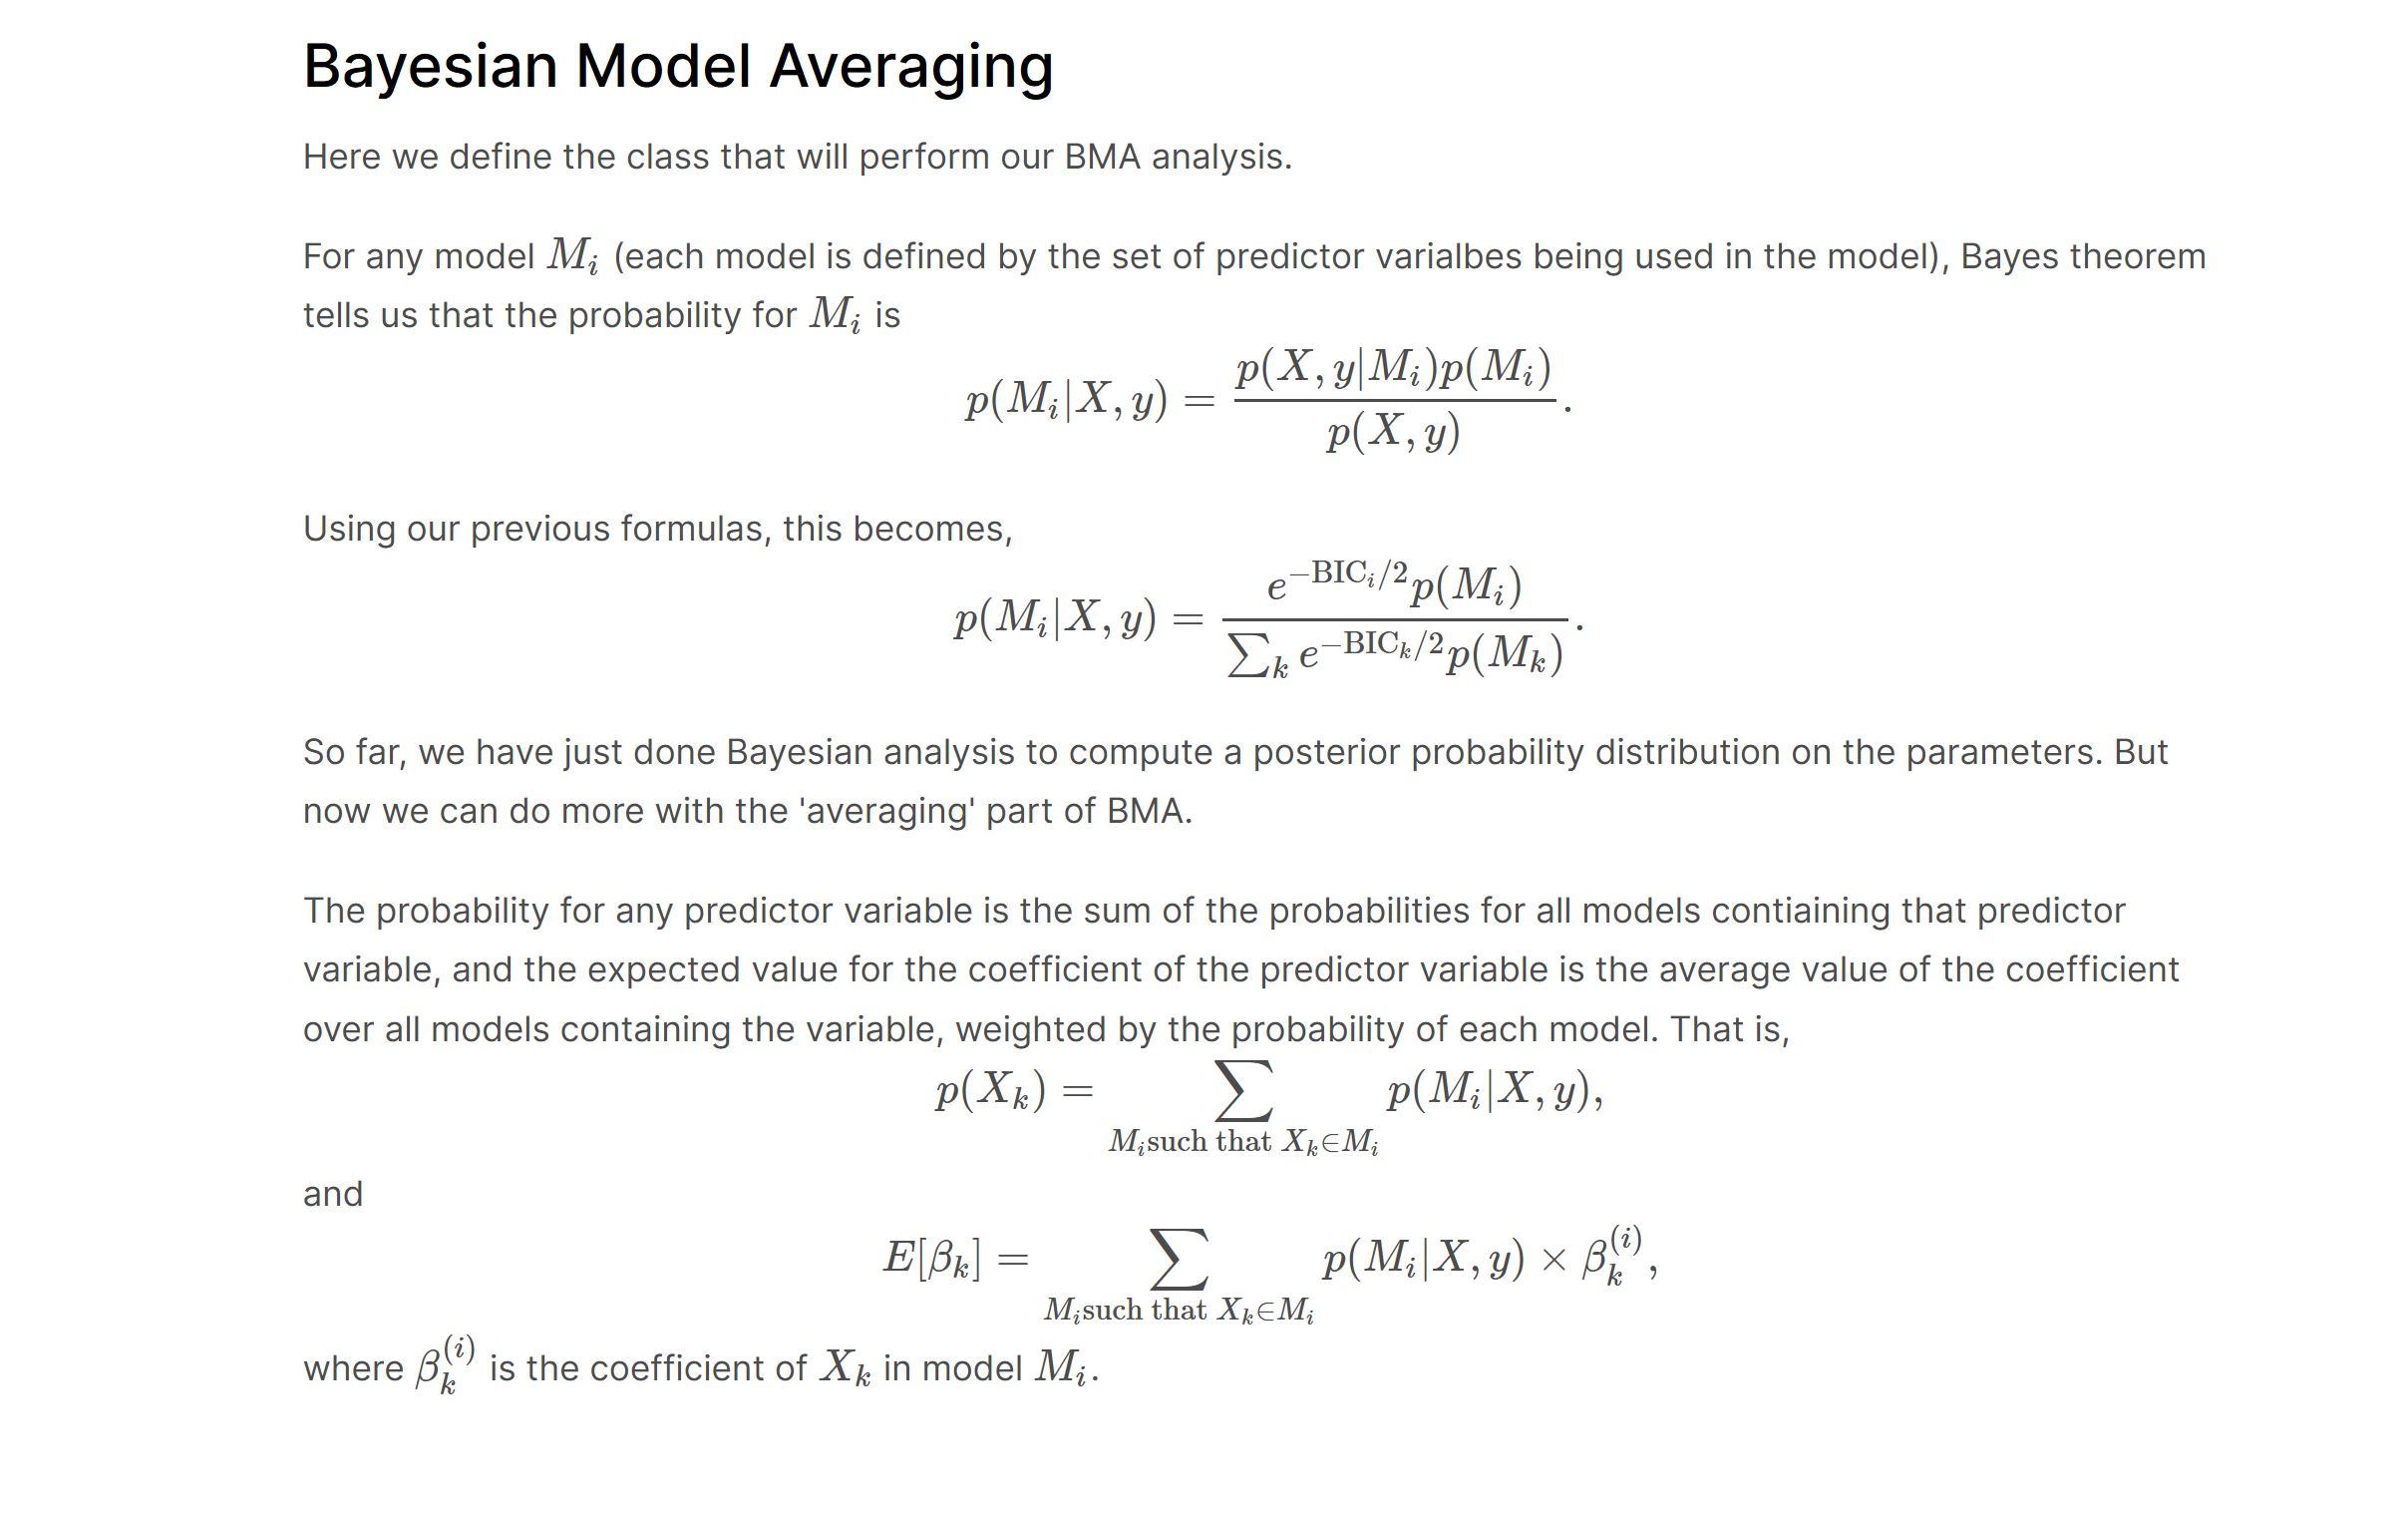

In [24]:
from mpmath import mp
mp.dps = 50
class BMA:
    
    def __init__(self, y, X, **kwargs):
        # Setup the basic variables.
        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.likelihoods_all = {}
        self.coefficients_mp = mp.zeros(self.nCols,1)
        self.coefficients = np.zeros(self.nCols)
        self.probabilities = np.zeros(self.nCols)
        # Check the max model size. (Max number of predictor variables to use in a model.)
        # This can be used to reduce the runtime but not doing an exhaustive sampling.
        if 'MaxVars' in kwargs.keys():
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        # Prepare the priors if they are provided.
        # The priors are provided for the individual regressor variables.
        # The prior for a model is the product of the priors on the variables in the model.
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        if 'RegType' in kwargs.keys():
            self.RegType = kwargs['RegType'] 
        else:
            self.RegType = 'LS' 
        
    def fit(self):
        # Perform the Bayesian Model Averaging
        
        # Initialize the sum of the likelihoods for all the models to zero.  
        # This will be the 'normalization' denominator in Bayes Theorem.
        likelighood_sum = 0
        
        # To facilitate iterating through all possible models, we start by iterating thorugh
        # the number of elements in the model.  
        max_likelihood = 0
        for num_elements in range(1,self.MaxVars+1): 
            
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            
            # Make a list of all index sets of models of this size.
            Models_next = list(combinations(list(range(self.nCols)), num_elements)) 
             
            # Occam's window - compute the candidate models to use for the next iteration
            # Models_previous: the set of models from the previous iteration that satisfy (likelihhod > max_likelihhod/20)
            # Models_next:     the set of candidate models for the next iteration
            # Models_current:  the set of models from Models_next that can be consturcted by adding one new variable
            #                    to a model from Models_previous
            if num_elements == 1:
                Models_current = Models_next
                Models_previous = []
            else:
                idx_keep = np.zeros(len(Models_next))
                for M_new,idx in zip(Models_next,range(len(Models_next))):
                    for M_good in Models_previous:
                        if(all(x in M_new for x in M_good)):
                            idx_keep[idx] = 1
                            break
                        else:
                            pass
                Models_current = np.asarray(Models_next)[np.where(idx_keep==1)].tolist()
                Models_previous = []
                        
            
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]
                if self.RegType == 'Logit':
                    model_regr = sm.Logit(self.y, model_X).fit(disp=0)
                else:
                    model_regr = OLS(self.y, model_X).fit()
                
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                    
                if (model_likelihood > max_likelihood/20):
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                    self.likelihoods_all[str(model_index_set)] = model_likelihood
                    
                    # Add this likelihood to the running tally of likelihoods.
                    likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)

                    # Add this likelihood (times the priors) to the running tally
                    # of likelihoods for each variable in the model.
                    for idx, i in zip(model_index_set, range(num_elements)):
                        self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=1000)
                        self.coefficients_mp[idx] = mp.fadd(self.coefficients_mp[idx], model_regr.params[i]*model_likelihood, prec=1000)
                    Models_previous.append(model_index_set) # add this model to the list of good models
                    max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
                else:
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"rejected by Occam's window")
                    

        # Divide by the denominator in Bayes theorem to normalize the probabilities 
        # sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            self.coefficients[idx] = mp.fdiv(self.coefficients_mp[idx],likelighood_sum, prec=1000)
        
        # Return the new BMA object as an output.
        return self
    
    def predict(self, data):
        data = np.asarray(data)
        if self.RegType == 'Logit':
            try:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data)))
            except:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data.T)))
        else:
            try:
                result = np.dot(self.coefficients,data)
            except:
                result = np.dot(self.coefficients,data.T)
        
        return result  
        
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df  

Now we split our data into input X dataframe and an output y datafram, and run our BMA analysis.

## __NOTE__ that we do not add a priors argument, because we can consider them all to be equally likely. Also, the BMA class assumes flat priors (reference the paper here)

In [25]:
result = BMA(y,add_constant(X), RegType = 'Logit', Verbose=True).fit()

Computing BMA for models of size:  1
Model Variables: (0,) likelihood= 3.8754067922324493686355492023386931388132284817194e-5973
Model Variables: (1,) likelihood= 9.7593709262812842114808648993716527507024686624886e-3323
Model Variables: (2,) rejected by Occam's window
Model Variables: (3,) rejected by Occam's window
Model Variables: (4,) rejected by Occam's window
Model Variables: (5,) rejected by Occam's window
Model Variables: (6,) rejected by Occam's window
Model Variables: (7,) rejected by Occam's window
Model Variables: (8,) rejected by Occam's window
Model Variables: (9,) rejected by Occam's window
Model Variables: (10,) rejected by Occam's window
Model Variables: (11,) rejected by Occam's window
Computing BMA for models of size:  2
Model Variables: [0, 1] likelihood= 6.1913338498490397850472187786545771598797459511609e-2934
Model Variables: [0, 2] rejected by Occam's window
Model Variables: [0, 3] rejected by Occam's window
Model Variables: [0, 4] likelihood= 1.4006937839768700

In [26]:
result.summary()

,Variable Name,Probability,Avg. Coefficient
0,const,0.0172836,-0.0129077
1,word_count,1,1.88106
2,question_mark,1,-67.7187
3,exclamation_point,1,-909.021
4,structure_count,1,0.0568335
5,format_count,1,0.196753
6,context_count,1,0.0247336
7,pronoun_count,1,-0.00540272
8,has_edu_suffix,0.998712,1.03328
9,formality,0.982716,-0.88596


In [27]:
result.likelihoods_all

{'(0,)': mpf('3.8754067922324493686355492023386931388132284817194098e-5973'),
 '(1,)': mpf('9.7593709262812842114808648993716527507024686624886346e-3323'),
 '[0, 1]': mpf('6.1913338498490397850472187786545771598797459511608918e-2934'),
 '[0, 4]': mpf('1.4006937839768700366872607348913804193384679346029491e-2536'),
 '[0, 5]': mpf('2.3660551625542764520509218532986651777790940301869469e-2059'),
 '[1, 5]': mpf('2.2685935072797824253743110549027168442396904601583194e-1880'),
 '[0, 1, 5]': mpf('1.9546412202640943504484598014007653802514617763810243e-1802'),
 '[0, 3, 5]': mpf('3.7090419750277367096509360274995747384930535583185032e-1782'),
 '[1, 3, 5]': mpf('6.2795387425520908865461691827816972140040259700344407e-1526'),
 '[0, 1, 3, 5]': mpf('5.7034384888472130451068177845687211263081579029836038e-1519'),
 '[1, 2, 3, 5]': mpf('7.8768325243090907097860647067927011990647388532717474e-1513'),
 '[1, 3, 4, 5]': mpf('3.6931717038839318309196609322900381899407716775616045e-1509'),
 '[1, 3, 5, 7]': 

In [28]:
len(result.likelihoods_all)

36

In [29]:
df_likelihoods = result.likelihoods_all

In [30]:
list(df_likelihoods.values())[0]

mpf('3.8754067922324493686355492023386931388132284817194098e-5973')

In [31]:
str(0) in list(df_likelihoods.keys())[0]

True

In [32]:
summation = {'sum': [0.0]*variableCount, 'likelihoods': [[]]*variableCount}
df_sum = pd.DataFrame(data=summation)
df_sum

,sum,likelihoods
0,0.0,[]
1,0.0,[]
2,0.0,[]
3,0.0,[]
4,0.0,[]
5,0.0,[]
6,0.0,[]
7,0.0,[]
8,0.0,[]
9,0.0,[]


In [33]:
type(df_sum.iloc[0,1])

list

In [34]:
# print(df_sum.iloc[8,1])

In [35]:
for i in range(len(df_likelihoods)):
    for j in range(variableCount):
        if str(j) in list(df_likelihoods.keys())[i]:
            # add to list of strings
            df_sum.iloc[j,1].append(list(df_likelihoods.values())[i])
            # add value to the sum
            df_sum.iloc[j,0] = df_sum.iloc[j,0] + list(df_likelihoods.values())[i]
df_sum

,sum,likelihoods
0,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...
1,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...
2,4.00741571959313011674190231508164670475844982...,[3.8754067922324493686355492023386931388132284...
3,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...
4,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...
5,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...
6,4.00741571955570735902033065906471874768633994...,[3.8754067922324493686355492023386931388132284...
7,4.00741571960202360710215919876721939897952581...,[3.8754067922324493686355492023386931388132284...
8,4.00225525481245463469299654875391063538064495...,[3.8754067922324493686355492023386931388132284...
9,3.93815312543168183278051318293058926196042182...,[3.8754067922324493686355492023386931388132284...


## First visualiztation to consider: relative importance of each predictor across all models (normalized for all models)

In [36]:
df_predictorView = df_sum
df_predictorView["normalizedImpact"] = [0.0]*variableCount
summation = df_predictorView.sum()[0]
for i in range(variableCount):
    df_predictorView.iloc[i,2] = df_predictorView.iloc[i,0]/summation
df_predictorView.iloc[0,2]

mpf('0.089625948452988037129455178347354810319726290622777891')

In [37]:
result.summary()["Variable Name"]

0                 const
1            word_count
2         question_mark
3     exclamation_point
4       structure_count
5          format_count
6         context_count
7         pronoun_count
8        has_edu_suffix
9             formality
10       has_meta_title
11    has_meta_abstract
Name: Variable Name, dtype: object

In [38]:
df_predictorView["Variable"] = result.summary()["Variable Name"]
df_predictorView["normalizedImpact"] = df_predictorView["normalizedImpact"].astype('float')
# type(df_predictorView["normalizedImpact"])
df_predictorView

,sum,likelihoods,normalizedImpact,Variable
0,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...,0.089626,const
1,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...,0.089626,word_count
2,4.00741571959313011674190231508164670475844982...,[3.8754067922324493686355492023386931388132284...,0.089626,question_mark
3,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...,0.089626,exclamation_point
4,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...,0.089626,structure_count
5,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...,0.089626,format_count
6,4.00741571955570735902033065906471874768633994...,[3.8754067922324493686355492023386931388132284...,0.089626,context_count
7,4.00741571960202360710215919876721939897952581...,[3.8754067922324493686355492023386931388132284...,0.089626,pronoun_count
8,4.00225525481245463469299654875391063538064495...,[3.8754067922324493686355492023386931388132284...,0.089511,has_edu_suffix
9,3.93815312543168183278051318293058926196042182...,[3.8754067922324493686355492023386931388132284...,0.088077,formality


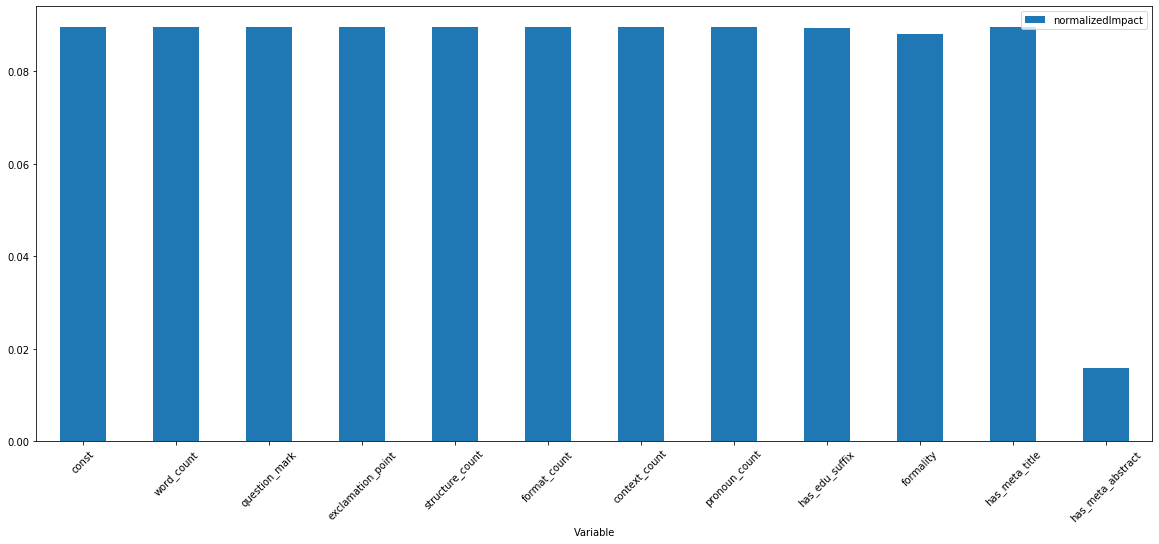

In [39]:
# df_predictorView["normalizedImpact"].hist()
plt.figure(figsize=(20,8))
plt.xticks(rotation=45)
ax = plt.gca()
df_predictorView.plot.bar(x='Variable', y='normalizedImpact', ax = ax, rot=45)

# Second Visualization: plotting the various predictors influence on each model relative to the whole (normalized for all models)

In [40]:
summation = {'model1': [0.0]*variableCount,
             'model2': [0.0]*variableCount,
             'model3': [0.0]*variableCount,
             'model4': [0.0]*variableCount,
             'model5': [0.0]*variableCount,
             'model6': [0.0]*variableCount,
             'model7': [0.0]*variableCount,
             'model8': [0.0]*variableCount,
             'model9': [0.0]*variableCount,
             'model10': [0.0]*variableCount,
             'model11': [0.0]*variableCount,
             'model12': [0.0]*variableCount,
             'model13': [0.0]*variableCount,
             'model14': [0.0]*variableCount,
             'model15': [0.0]*variableCount,
             'model16': [0.0]*variableCount,
             'model17': [0.0]*variableCount,
             'model18': [0.0]*variableCount,
             'model19': [0.0]*variableCount,
             'model20': [0.0]*variableCount,
             'model21': [0.0]*variableCount,
             'model22': [0.0]*variableCount,
             'model23': [0.0]*variableCount,
             'model24': [0.0]*variableCount,
             'model25': [0.0]*variableCount,
             'model26': [0.0]*variableCount,
             'model27': [0.0]*variableCount,
             'model28': [0.0]*variableCount,
             'model29': [0.0]*variableCount,
             'model30': [0.0]*variableCount,
             'model31': [0.0]*variableCount,
             'model32': [0.0]*variableCount,
             'model33': [0.0]*variableCount,
             'model34': [0.0]*variableCount,
             'model35': [0.0]*variableCount,
             'model36': [0.0]*variableCount
#              'model37': [0.0]*variableCount
#              'model38': [0.0]*variableCount,
#              'model39': [0.0]*variableCount
            }
df_predictor = pd.DataFrame(data=summation)
df_predictor


#              'model21': [0.0]*variableCount,
#              'model22': [0.0]*variableCount,
#              'model23': [0.0]*variableCount,
#              'model24': [0.0]*variableCount,
#              'model25': [0.0]*variableCount,
#              'model26': [0.0]*variableCount,
#              'model27': [0.0]*variableCount,
#              'model28': [0.0]*variableCount,
#              'model29': [0.0]*variableCount,
#              'model30': [0.0]*variableCount,
#              'model31': [0.0]*variableCount,
#              'model32': [0.0]*variableCount,
#              'model33': [0.0]*variableCount,
#              'model34': [0.0]*variableCount,
#              'model35': [0.0]*variableCount,
#              'model36': [0.0]*variableCount,
#              'model37': [0.0]*variableCount,
#              'model38': [0.0]*variableCount,
#              'model39': [0.0]*variableCount,
#              'model40': [0.0]*variableCount,
#              'model41': [0.0]*variableCount,
#              'model42': [0.0]*variableCount,
#              'model42': [0.0]*variableCount,
#              'model43': [0.0]*variableCount,
#              'model44': [0.0]*variableCount,
#              'model45': [0.0]*variableCount,
#              'model46': [0.0]*variableCount,
#              'model47': [0.0]*variableCount,
#              'model48': [0.0]*variableCount,
#              'model49': [0.0]*variableCount,
#              'model50': [0.0]*variableCount,
#              'model51': [0.0]*variableCount,
#              'model52': [0.0]*variableCount,
#              'model53': [0.0]*variableCount

,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,...,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
df_predictorByModelView_NormalizedByTotal = df_sum
summation = df_predictorByModelView_NormalizedByTotal.sum()[0]
summation
# for i in range(10):
#     df_predictorView.iloc[i,2] = df_predictorView.iloc[i,0]/summation
# df_predictorView.iloc[0,2]

mpf('4.4712672934319155012998235087613643777939018283604259e-1319')

In [42]:
len(df_likelihoods)

36

In [43]:
for i in range(len(df_likelihoods)):
    for j in range(variableCount,):
#         print(str(i)+" and "+str(j))
        if str(j) in list(df_likelihoods.keys())[i]:
            #enter the value into the dataframe
            df_predictor.iloc[j,i] = float(list(df_likelihoods.values())[i]/summation)
            
            
df_predictor["Variable"] = result.summary()["Variable Name"]
# df_predictor["normalizedImpact"] = df_predictor["normalizedImpact"].astype('float')
df_predictor           

,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,...,model28,model29,model30,model31,model32,model33,model34,model35,model36,Variable
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.275575e-200,...,5.743248e-14,9.347087e-14,1.080580e-12,2.438654e-13,0.000005,0.000111,0.001544,0.072187,0.015779,const
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.404420e-207,1.275575e-200,...,5.743248e-14,9.347087e-14,1.080580e-12,2.438654e-13,0.000005,0.000111,0.001544,0.072187,0.015779,word_count
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,9.347087e-14,1.080580e-12,0.000000e+00,0.000005,0.000111,0.001544,0.072187,0.015779,question_mark
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.404420e-207,1.275575e-200,...,5.743248e-14,9.347087e-14,1.080580e-12,2.438654e-13,0.000005,0.000111,0.001544,0.072187,0.015779,exclamation_point
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,5.743248e-14,9.347087e-14,1.080580e-12,2.438654e-13,0.000005,0.000111,0.001544,0.072187,0.015779,structure_count
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.404420e-207,1.275575e-200,...,5.743248e-14,9.347087e-14,1.080580e-12,2.438654e-13,0.000005,0.000111,0.001544,0.072187,0.015779,format_count
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,5.743248e-14,9.347087e-14,0.000000e+00,2.438654e-13,0.000005,0.000111,0.001544,0.072187,0.015779,context_count
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,5.743248e-14,0.000000e+00,1.080580e-12,2.438654e-13,0.000005,0.000111,0.001544,0.072187,0.015779,pronoun_count
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.001544,0.072187,0.015779,has_edu_suffix
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,9.347087e-14,1.080580e-12,2.438654e-13,0.000000,0.000111,0.000000,0.072187,0.015779,formality


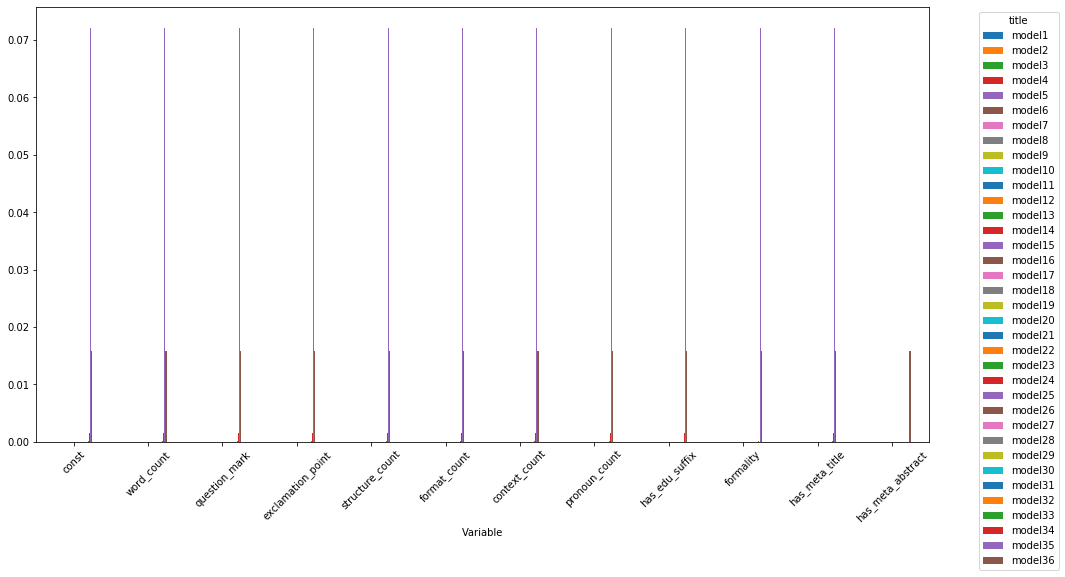

In [44]:
plt.figure(figsize=(16,8))

ax = plt.gca()
# df_predictor.plot(x="Variable", y=["model1", "model2", "model3", "model4", "model5", "model6", "model7", "model8", "model9", "model10", "model11", "model12", "model13", "model14", "model15", "model16", "model17", "model18", "model19", "model20", "model21", "model22", "model23", "model24", "model25", "model26"],ax=ax,  kind="bar", rot = 45)
#, "model21", "model22", "model23", "model24", "model25", "model26", "model27", "model28", "model29", "model30", "model31", "model32", "model33", "model34", "model35", "model36", "model37", "model38", "model39", "model40", "model41", "model42", "model43", "model44",  "model45", "model46", "model47", "model48", "model49", "model50", "model51", "model52", "model53"
df_predictor.plot(x="Variable", y=["model1", "model2", "model3", "model4", "model5", "model6", "model7", "model8", "model9", "model10", "model11", "model12", "model13", "model14", "model15", "model16", "model17", "model18", "model19", "model20", "model21", "model22", "model23", "model24", "model25", "model26",
 "model27", "model28", "model29", "model30", "model31", "model32", "model33", "model34", "model35", "model36"],ax=ax,  kind="bar", stacked = False, rot = 45) #, "model13", "model14", "model15", "model16", "model17", "model18", "model19", "model20"

plt.legend(title='title', bbox_to_anchor=(1.05, 1), loc='upper left')

# Second Visualization (view 2): plotting the various predictors influence on each model relative to the whole (normalized for all models)

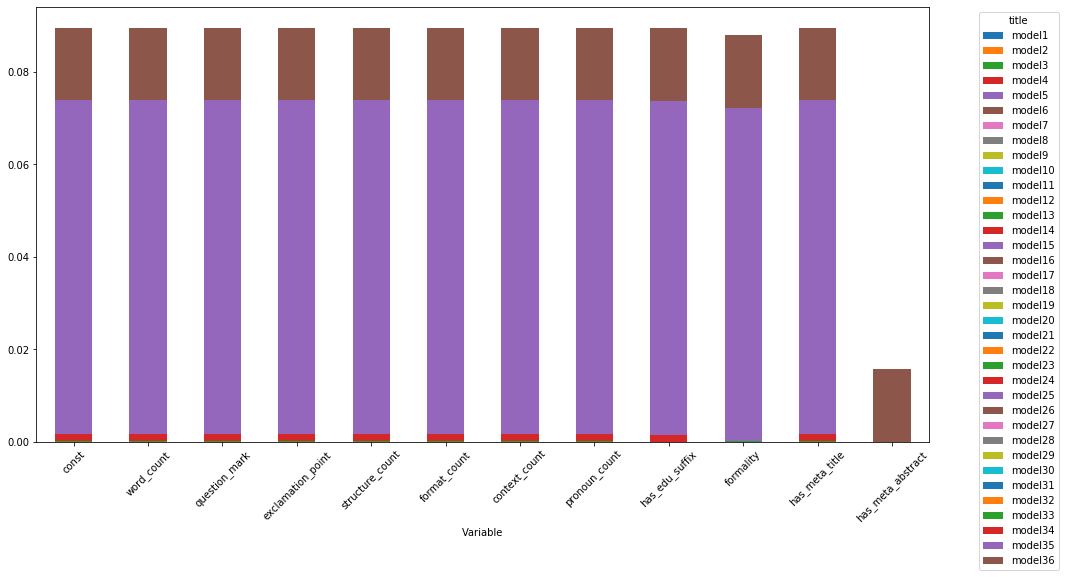

In [45]:
plt.figure(figsize=(16,8))

ax = plt.gca()
# df_predictor.plot(x="Variable", y=["model1", "model2", "model3", "model4", "model5", "model6", "model7", "model8", "model9", "model10", "model11", "model12", "model13", "model14", "model15", "model16", "model17", "model18", "model19", "model20", "model21", "model22", "model23", "model24", "model25", "model26"],ax=ax,  kind="bar", stacked = True, rot = 45)
df_predictor.plot(x="Variable", y=["model1", "model2", "model3", "model4", "model5", "model6", "model7", "model8", "model9", "model10", "model11", "model12", "model13", "model14", "model15", "model16", "model17", "model18", "model19", "model20", "model21", "model22", "model23", "model24", "model25", "model26",
 "model27", "model28", "model29", "model30", "model31", "model32", "model33", "model34", "model35", "model36"],ax=ax,  kind="bar", stacked = True, rot = 45) # , "model13", "model14", "model15", "model16", "model17", "model18", "model19", "model20"

plt.legend(title='title', bbox_to_anchor=(1.05, 1), loc='upper left')

In [46]:
df_predictor_heatMap = df_predictor
df_predictor_heatMap = df_predictor_heatMap.set_index('Variable')


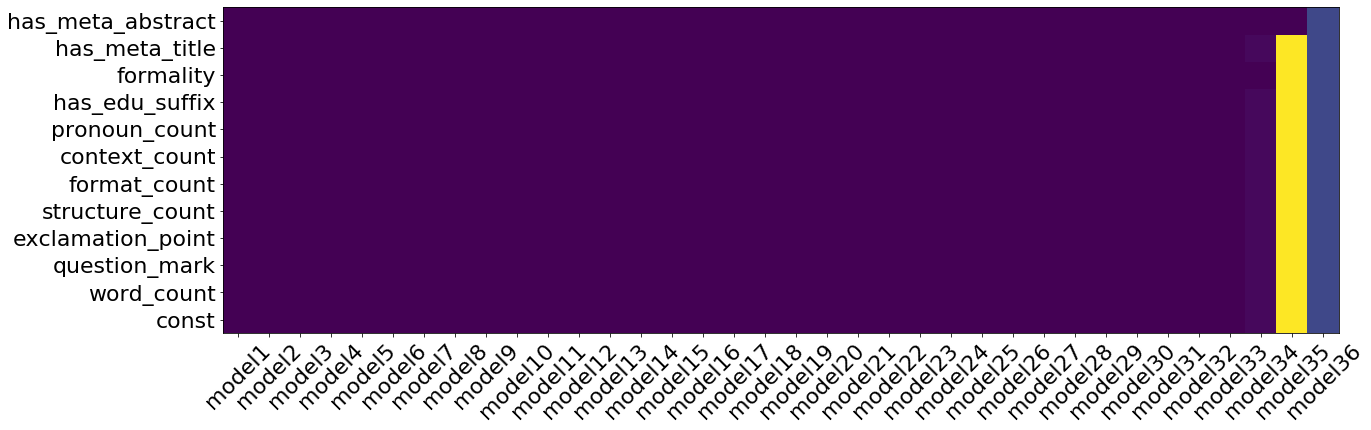

In [49]:
plt.figure(figsize=(20,6))

# ax = plt.gca()
# df_predictor.plot(x="Variable", y=["model1", "model2", "model3", "model4", "model5", "model6", "model7", "model8", "model9", "model10", "model11", "model12", "model13", "model14", "model15", "model16", "model17", "model18", "model19", "model20", "model21", "model22", "model23", "model24", "model25", "model26", "model27", "model28"],ax=ax,  kind="bar", stacked = True)

# plt.imshow(df_predictor, cmap='hot')
# plt.show()

plt.pcolor(df_predictor_heatMap)
plt.yticks(np.arange(0.5, len(df_predictor_heatMap.index), 1), df_predictor_heatMap.index)
plt.xticks(np.arange(0.5, len(df_predictor_heatMap.columns), 1), df_predictor_heatMap.columns, rotation = 45)
plt.rcParams.update({'font.size': 202})
plt.show()

# index = ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
# columns = ['A', 'B', 'C', 'D']
# df = pd.DataFrame(abs(np.random.randn(5, 4)), index=index, columns=columns)

# plt.pcolor(df)
# plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
# plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
# plt.show()
# df

# df_predictor.iloc[1,1]

# Third Visualization - looking at each predictor individually and seeing which models it influences the most (normalized for each predictor - not the total)

In [171]:
summation = {'model1': [0.0]*variableCount,
             'model2': [0.0]*variableCount,
             'model3': [0.0]*variableCount,
             'model4': [0.0]*variableCount,
             'model5': [0.0]*variableCount,
             'model6': [0.0]*variableCount,
             'model7': [0.0]*variableCount,
             'model8': [0.0]*variableCount,
             'model9': [0.0]*variableCount,
             'model10': [0.0]*variableCount,
             'model11': [0.0]*variableCount,
             'model12': [0.0]*variableCount,
             'model13': [0.0]*variableCount,
             'model14': [0.0]*variableCount,
             'model15': [0.0]*variableCount,
             'model16': [0.0]*variableCount,
             'model17': [0.0]*variableCount,
             'model18': [0.0]*variableCount,
             'model19': [0.0]*variableCount,
             'model20': [0.0]*variableCount,
             'model22': [0.0]*variableCount,
             'model23': [0.0]*variableCount,
             'model24': [0.0]*variableCount,
             'model25': [0.0]*variableCount,
             'model26': [0.0]*variableCount,
             'model27': [0.0]*variableCount,
             'model28': [0.0]*variableCount,
             'model29': [0.0]*variableCount,
             'model30': [0.0]*variableCount,
             'model31': [0.0]*variableCount,
             'model32': [0.0]*variableCount,
             'model33': [0.0]*variableCount,
             'model34': [0.0]*variableCount,
             'model35': [0.0]*variableCount,
             'model36': [0.0]*variableCount,
             'model37': [0.0]*variableCount,
            }
df_predictor = pd.DataFrame(data=summation)
df_predictor


# 'model21': [0.0]*variableCount,
#              'model22': [0.0]*variableCount,
#              'model23': [0.0]*variableCount,
#              'model24': [0.0]*variableCount,
#              'model25': [0.0]*variableCount,
#              'model26': [0.0]*variableCount,
#              'model27': [0.0]*variableCount,
#              'model28': [0.0]*variableCount,
#              'model29': [0.0]*variableCount,
#              'model30': [0.0]*variableCount,
#              'model31': [0.0]*variableCount,
#              'model32': [0.0]*variableCount,
#              'model33': [0.0]*variableCount,
#              'model34': [0.0]*variableCount,
#              'model35': [0.0]*variableCount,
#              'model36': [0.0]*variableCount,
#              'model37': [0.0]*variableCount,
#              'model38': [0.0]*variableCount,
#              'model39': [0.0]*variableCount,
#              'model40': [0.0]*variableCount,
#              'model41': [0.0]*variableCount,
#              'model42': [0.0]*variableCount,
#              'model42': [0.0]*variableCount,
#              'model43': [0.0]*variableCount,
#              'model44': [0.0]*variableCount,
#              'model45': [0.0]*variableCount,
#              'model46': [0.0]*variableCount,
#              'model47': [0.0]*variableCount,
#              'model48': [0.0]*variableCount,
#              'model49': [0.0]*variableCount,
#              'model50': [0.0]*variableCount,
#              'model51': [0.0]*variableCount,
#              'model52': [0.0]*variableCount,
#              'model53': [0.0]*variableCount

,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,...,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [172]:
summation = {'sum': [0.0]*variableCount, 'likelihoods': [[]]*variableCount}
df_sum = pd.DataFrame(data=summation)
df_sum

,sum,likelihoods
0,0.0,[]
1,0.0,[]
2,0.0,[]
3,0.0,[]
4,0.0,[]
5,0.0,[]
6,0.0,[]
7,0.0,[]
8,0.0,[]
9,0.0,[]


In [173]:
# Get the summation for each individual predictor
for i in range(len(df_likelihoods)):
    for j in range(variableCount):
        if str(j) in list(df_likelihoods.keys())[i]:
            # add to list of strings
            df_sum.iloc[j,1].append(list(df_likelihoods.values())[i])
            # add value to the sum
            df_sum.iloc[j,0] = df_sum.iloc[j,0] + list(df_likelihoods.values())[i]
df_sum

,sum,likelihoods
0,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...
1,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...
2,4.00741571959313011674190231508164670475844982...,[3.8754067922324493686355492023386931388132284...
3,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...
4,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...
5,4.00741571960660194992747015199024642514038197...,[3.8754067922324493686355492023386931388132284...
6,4.00741571955570735902033065906471874768633994...,[3.8754067922324493686355492023386931388132284...
7,4.00741571960202360710215919876721939897952581...,[3.8754067922324493686355492023386931388132284...
8,4.00225525481245463469299654875391063538064495...,[3.8754067922324493686355492023386931388132284...
9,3.93815312543168183278051318293058926196042182...,[3.8754067922324493686355492023386931388132284...


In [174]:
df_sum.iloc[0,0]

mpf('4.0074157196066019499274701519902464251403819762159865e-1320')

In [175]:
# get the likelihoods by model, then normailize by predictor
for i in range(len(df_likelihoods)):
    for j in range(variableCount):
#         print(str(i)+" and "+str(j))
        if str(j) in list(df_likelihoods.keys())[i]:
            #enter the value into the dataframe
            df_predictor.iloc[j,i] = float(list(df_likelihoods.values())[i]/df_sum.iloc[j,0])
            
            
df_predictor["Variable"] = result.summary()["Variable Name"]
# df_predictor["normalizedImpact"] = df_predictor["normalizedImpact"].astype('float')
df_predictor         

,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,...,model29,model30,model31,model32,model33,model34,model35,model36,model37,Variable
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.423221e-199,...,6.408019e-13,1.042900e-12,1.205656e-11,2.720924e-12,0.000053,0.001235,0.017231,0.805427,0.176054,const
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.566980e-206,1.423221e-199,...,6.408019e-13,1.042900e-12,1.205656e-11,2.720924e-12,0.000053,0.001235,0.017231,0.805427,0.176054,word_count
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,1.042900e-12,1.205656e-11,0.000000e+00,0.000053,0.001235,0.017231,0.805427,0.176054,question_mark
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.566980e-206,1.423221e-199,...,6.408019e-13,1.042900e-12,1.205656e-11,2.720924e-12,0.000053,0.001235,0.017231,0.805427,0.176054,exclamation_point
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,6.408019e-13,1.042900e-12,1.205656e-11,2.720924e-12,0.000053,0.001235,0.017231,0.805427,0.176054,structure_count
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.566980e-206,1.423221e-199,...,6.408019e-13,1.042900e-12,1.205656e-11,2.720924e-12,0.000053,0.001235,0.017231,0.805427,0.176054,format_count
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,6.408019e-13,1.042900e-12,0.000000e+00,2.720924e-12,0.000053,0.001235,0.017231,0.805427,0.176054,context_count
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,6.408019e-13,0.000000e+00,1.205656e-11,2.720924e-12,0.000053,0.001235,0.017231,0.805427,0.176054,pronoun_count
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.017253,0.806466,0.176281,has_edu_suffix
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,1.061242e-12,1.226860e-11,2.768778e-12,0.000000,0.001256,0.000000,0.819593,0.179151,formality


# Third Visualization - View 1

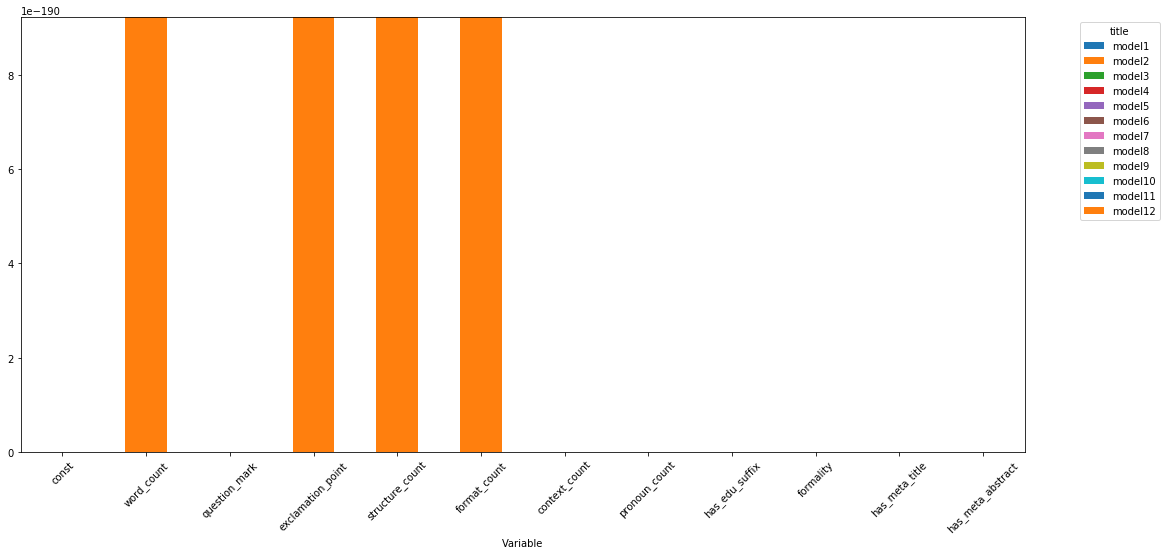

In [180]:
plt.figure(figsize=(18,8))

ax = plt.gca()
df_predictor.plot(x="Variable", y=["model1", "model2", "model3", "model4", "model5", "model6", "model7", "model8", "model9", "model10", "model11", "model12"],ax=ax,  kind="bar", stacked = True, rot = 45) #, "model13", "model14", "model15", "model16", "model17", "model18", "model19", "model20"
plt.legend(title='title', bbox_to_anchor=(1.05, 1), loc='upper left')

# Third Visualization - View 2

In [181]:
df_predictor.loc[[0]]

,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,...,model29,model30,model31,model32,model33,model34,model35,model36,model37,Variable
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.423221e-199,...,6.408019e-13,1.042900e-12,1.205656e-11,2.720924e-12,0.000053,0.001235,0.017231,0.805427,0.176054,const


KeyError: "['model21'] not in index"

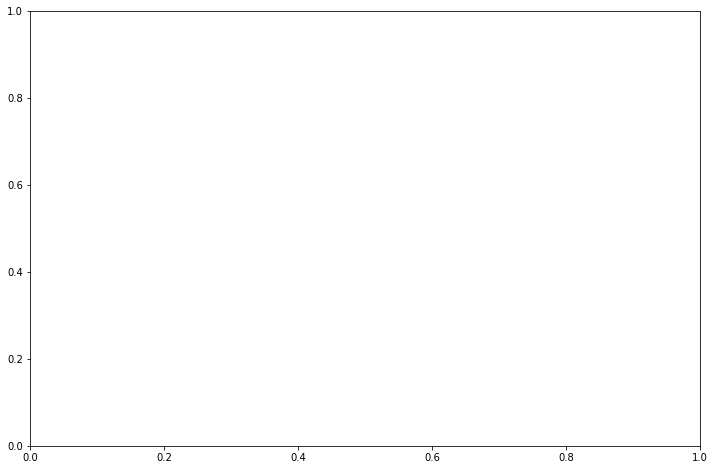

In [182]:
# plot by each predictor
for i in range(variableCount):
    plt.figure(figsize=(12,8))
    ax = plt.gca()
    df_predictor.loc[[i]].plot(x="Variable", y=["model1", "model2", "model3", "model4", "model5", "model6", "model7", "model8", "model9", "model10", "model11", "model12", "model13", "model14", "model15", "model16", "model17", "model18", "model19", "model20", "model21", "model22", "model23", "model24", "model25", "model26"],ax=ax,  kind="bar")

# Consider Simpler Models with Nonlinear Transformations, use WAIC to recommend

Based on Problem 3, I have chosen to drop some predcitors and only include those that scored highest ("alcohol", "adiposity", "sbp", "obesity")
I will look at three models. One with just the reduction in predictors, and then two more with increasing polynomial transformations on the age variable.

Please note that the sampling/trace method isn't as robust as would be preferred due to timing constraints (My machine was not able to process the runs in a timely manner)

In [113]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [114]:
from collections import OrderedDict

In [115]:
import theano

In [116]:
#  conda install -c conda-forge pymc3 

In [118]:
# model_regr = sm.Logit(self.y, model_X).fit(disp=0)

In [123]:
text_data.columns

Index(['Unnamed: 0', 'html_file', 'source', 'research', 'content',
       'contains_abstract', 'contains_introduction', 'contains_methods',
       'contains_results', 'contains_background', 'contains_discussion',
       'contains_conclusion', 'contains_references', 'contains_mentions',
       'word_count'],
      dtype='object')

In [124]:
# Model 1
X = text_data.drop(['Unnamed: 0', 'html_file', 'source', 'research', 'content',
       'contains_introduction', 'contains_methods',
       'contains_results', 'contains_discussion',
       'contains_mentions',
       ], axis=1)
y = text_data["research"]
# building the model and fitting the data 
log_reg2 = sm.Logit(y, add_constant(X)).fit()
log_reg2.summary()

Optimization terminated successfully.
         Current function value: 0.437260
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               research   No. Observations:                 3530
Model:                          Logit   Df Residuals:                     3524
Method:                           MLE   Df Model:                            5
Date:                Sat, 14 Nov 2020   Pseudo R-squ.:                  0.3650
Time:                        16:25:25   Log-Likelihood:                -1543.5
converged:                       True   LL-Null:                       -2430.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.3680      0.059     -6.255      0.000      -0.483      -0.253
contains_abstract       4.3004      0.233     18.468      0.000       3.844       4.757
contains_background    -1.4345      0.114    -12.547      0.000      -1.659      -1.210
contains_conclusion     1.7624      0.381      4.624      0.000       1.015       2.509
contains_references     0.5705      0.163      3.506      0.000       0.252       0.889
word_count             -0.5333      0.090     -5.898      0.000      -0.710      -0.356
=======================================================================================
"""

In [126]:
# Model 2
X = text_data.drop(['Unnamed: 0', 'html_file', 'source', 'research', 'content',
       'contains_introduction', 'contains_methods',
       'contains_results', 'contains_discussion',
       'contains_mentions',
       ], axis=1)
X['word_count'] = np.square(X['word_count']) 
y = text_data["research"]
# building the model and fitting the data 
log_reg2 = sm.Logit(y, add_constant(X)).fit()
log_reg2.summary()

Optimization terminated successfully.
         Current function value: 0.440087
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               research   No. Observations:                 3530
Model:                          Logit   Df Residuals:                     3524
Method:                           MLE   Df Model:                            5
Date:                Sat, 14 Nov 2020   Pseudo R-squ.:                  0.3609
Time:                        16:26:33   Log-Likelihood:                -1553.5
converged:                       True   LL-Null:                       -2430.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1879      0.051     -3.714      0.000      -0.287      -0.089
contains_abstract       4.2379      0.228     18.551      0.000       3.790       4.686
contains_background    -1.5805      0.111    -14.266      0.000      -1.798      -1.363
contains_conclusion     1.5845      0.382      4.149      0.000       0.836       2.333
contains_references     0.4681      0.159      2.944      0.003       0.157       0.780
word_count             -0.1200      0.029     -4.152      0.000      -0.177      -0.063
=======================================================================================
"""

In [127]:
# Model 3
X = text_data.drop(['Unnamed: 0', 'html_file', 'source', 'research', 'content',
       'contains_introduction', 'contains_methods',
       'contains_results', 'contains_discussion',
       'contains_mentions',
       ], axis=1)
X['word_count'] = np.square(X['word_count'])
X['word_count'] = X['word_count']*X['word_count']*X['word_count']
y = text_data["research"]
# building the model and fitting the data 
log_reg2 = sm.Logit(y, add_constant(X)).fit()
log_reg2.summary()

Optimization terminated successfully.
         Current function value: 0.441975
         Iterations 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               research   No. Observations:                 3530
Model:                          Logit   Df Residuals:                     3524
Method:                           MLE   Df Model:                            5
Date:                Sat, 14 Nov 2020   Pseudo R-squ.:                  0.3582
Time:                        16:27:13   Log-Likelihood:                -1560.2
converged:                       True   LL-Null:                       -2430.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2020      0.051     -3.998      0.000      -0.301      -0.103
contains_abstract       4.1153      0.216     19.083      0.000       3.693       4.538
contains_background    -1.6273      0.110    -14.770      0.000      -1.843      -1.411
contains_conclusion     1.3997      0.387      3.621      0.000       0.642       2.157
contains_references     0.3872      0.156      2.483      0.013       0.082       0.693
word_count             -0.0001   6.29e-05     -2.066      0.039      -0.000   -6.67e-06
=======================================================================================
"""

The following post was particularly helpful in understanding WAIC
The following two code blocks were borrowed from this public post. Credit goes to author Susan Li
https://towardsdatascience.com/building-a-bayesian-logistic-regression-with-python-and-pymc3-4dd463bbb16

Please note that we have made some alterations to the code in order to apply it to this project

In [128]:
X.columns

Index(['contains_abstract', 'contains_background', 'contains_conclusion',
       'contains_references', 'word_count'],
      dtype='object')

In [130]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)
#         X, y = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            
            pm.glm.GLM.from_formula(fml, df,
                                    family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(10, tune=10, init='adapt_diag')

    return models, traces

def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    print(('research ~ contains_abstract, contains_background, contains_conclusion, contains_references, word_count' + ' '.join(['+ np.power(word_count,{})'.format(j)
                                     for j in range(2,k+1)])).strip())
    return('research ~ contains_abstract, contains_background, contains_conclusion, contains_references, word_count' + ' '.join(['+ np.power(word_count,{})'.format(j)
                                     for j in range(2,k+1)])).strip()

models_lin, traces_lin = run_models(text_data, 3)

research ~ contains_abstract, contains_background, contains_conclusion, contains_references, word_count

Running: k1


PatsyError: Number of rows mismatch between data argument and contains_abstract, contains_background, contains_conclusion, contains_references, word_count (3530 versus 5)
    research ~ contains_abstract, contains_background, contains_conclusion, contains_references, word_count
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [138]:
model_trace_dict = dict()
for nm in ['k1', 'k2', 'k3']:
    models_lin[nm].name = nm
    model_trace_dict.update({models_lin[nm]: traces_lin[nm]})
dfwaic = pm.compare(model_trace_dict, ic='WAIC', scale = 'deviance')
dfwaic

C:\Users\John\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\John\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\John\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\John

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
<pymc3.model.Model object at 0x00000197136D0780>,0,487.452,6.5861,0,0.553937,21.7455,0,False,deviance
<pymc3.model.Model object at 0x0000019712BD9898>,1,489.953,8.32849,2.50036,0.189992,21.7299,2.30317,False,deviance
<pymc3.model.Model object at 0x0000019712269C88>,2,490.188,8.65738,2.73555,0.256071,22.2227,3.82335,True,deviance


# Problem 5
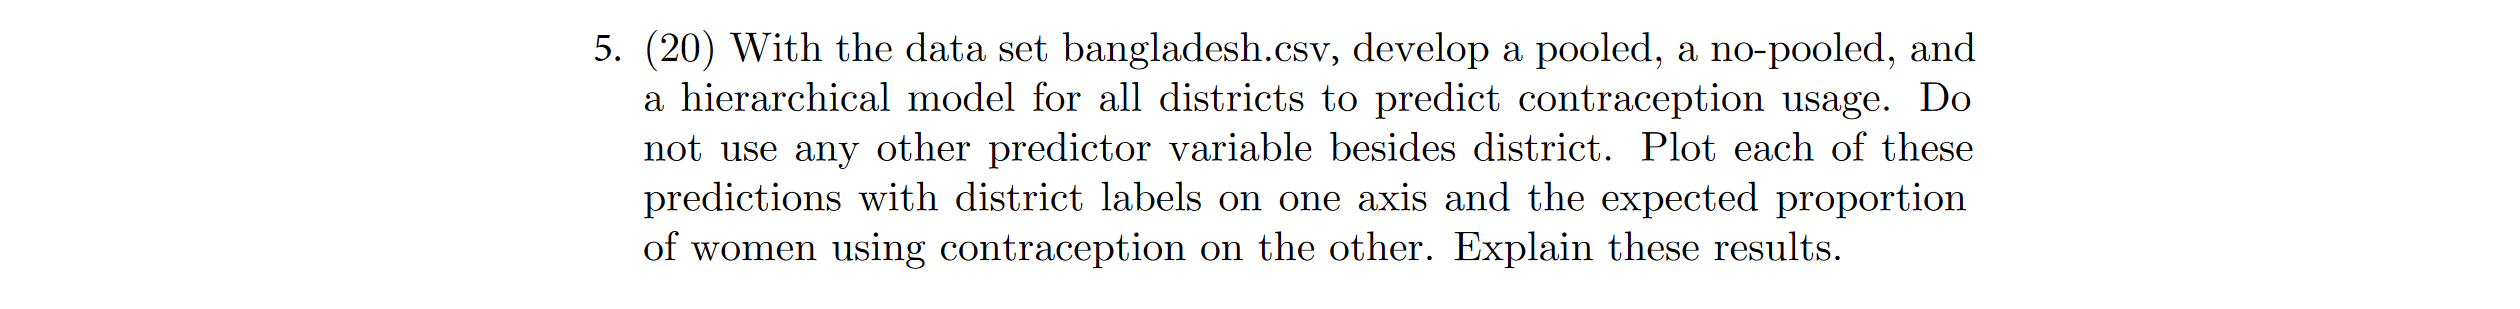

Check out https://docs.pymc.io/notebooks/model_comparison.html

In [426]:
import pymc3 as pm

import arviz as az

In [415]:
bangladesh_data = pd.read_csv("bangladesh.csv")
bangladesh_data.describe()

,woman,district,use.contraception,living.children,age.centered,urban
count,1934.000000,1934.000000,1934.000000,1934.000000,1934.000000,1934.000000
mean,967.500000,29.353671,0.392451,2.652017,0.002198,0.290589
std,558.442029,17.959835,0.488422,1.242631,9.013244,0.454152
min,1.000000,1.000000,0.000000,1.000000,-13.560000,0.000000
25%,484.250000,14.000000,0.000000,1.000000,-7.559900,0.000000
50%,967.500000,29.000000,0.000000,3.000000,-1.559900,0.000000
75%,1450.750000,45.000000,1.000000,4.000000,6.440000,1.000000
max,1934.000000,61.000000,1.000000,4.000000,19.440000,1.000000


In [432]:

bangladesh_data = bangladesh_data.rename({"use.contraception":"contraception"}, axis=1)
bangladesh_data.head()

,woman,district,contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


In [438]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz

In [433]:
district = bangladesh_data.district.values
contraception = bangladesh_data.contraception.values

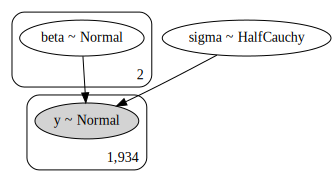

In [439]:
with Model() as pooled_model:
    beta = pm.Normal('beta', 0, sd=1e5, shape = 2)
    sigma = pm.HalfCauchy('sigma', 5)
    theta = beta[0]+beta[1]*district
    y= pm.Normal('y', theta, sd = sigma, observed = contraception)
pm.model_to_graphviz(pooled_model)

In [442]:
with pooled_model:
    pooled_trace = pm.sample(10, cores = 4, tune = 10)

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]
Sampling 4 chains, 1 divergences: 100%|██████████| 80/80 [01:39<00:00,  1.24s/draws]
C:\Users\John\Anaconda3\lib\site-packages\pymc3\sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


C:\Users\John\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001971FD9A828>,
      dtype=object)

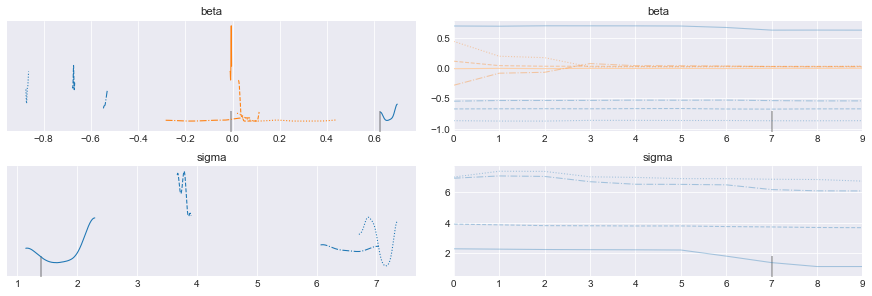

In [443]:
pm.traceplot(pooled_trace)

In [ ]:
b0, m0 = pooled_trace['beta'].mean(axis=0)

In [ ]:
# # Plot of the pooled models
# plt.scatter(district, )


In [446]:
# unpooled model

with Model() as unpooled_model:
    beta0 = pm.Normal('beta0', 0, sd=1e5, shape = district)
    beta1 = pm.Normal('beta0', 0, sd=1e5)
    sigma = pm.HalfCauchy('sigma', 5)
    theta = beta0[district]+beta[1]*district
    y= pm.Normal('y', theta, sd = sigma, observed = contraception)
pm.model_to_graphviz(pooled_model)

In [447]:
with Model() as unpooled_model:
    beta0 = pm.Normal('beta0', 0, sd=1e5, shape = district)
    beta1 = pm.Normal('beta0', 0, sd=1e5)
    sigma = pm.HalfCauchy('sigma', 5)
    theta = beta0[district]+beta[1]
    y= pm.Normal('y', theta, sd = sigma, observed = contraception)
pm.model_to_graphviz(pooled_model)

ValueError: maximum supported dimension for an ndarray is 32, found 1934

### Pooled model

In [419]:
y = bangladesh_data["use.contraception"]
sigma = 

0       0
1       0
2       0
3       0
4       0
       ..
1929    0
1930    0
1931    0
1932    0
1933    0
Name: use.contraception, Length: 1934, dtype: int64

In [ ]:
with pm.Model() as pooled:
    mu = pm.Normal('mu', 0, sigma=1e6)

    obs = pm.Normal('obs', mu, sigma=sigma, observed=y)

    trace_p = pm.sample(1000)

In [ ]:
pm.traceplot(trace_p)

In [1]:
 conda install -c conda-forge theano 

Solving environment: ...working... done

# All requested packages already installed.



Note: you may need to restart the kernel to use updated packages.


The system cannot find the file specified.
The system cannot find the path specified.
The system cannot find the path specified.


C:\Users\John\OneDrive\Documents\MSDS\DS 6014\Homeworks\Homework 3>SET DISTUTILS_USE_SDK=1 

C:\Users\John\OneDrive\Documents\MSDS\DS 6014\Homeworks\Homework 3>SET MSSdk=1 

C:\Users\John\OneDrive\Documents\MSDS\DS 6014\Homeworks\Homework 3>SET "VS_VERSION=15.0" 

C:\Users\John\OneDrive\Documents\MSDS\DS 6014\Homeworks\Homework 3>SET "VS_MAJOR=15" 

C:\Users\John\OneDrive\Documents\MSDS\DS 6014\Homeworks\Homework 3>SET "VS_YEAR=2017" 

C:\Users\John\OneDrive\Documents\MSDS\DS 6014\Homeworks\Homework 3>set "MSYS2_ARG_CONV_EXCL=/AI;/AL;/OUT;/out" 

C:\Users\John\OneDrive\Documents\MSDS\DS 6014\Homeworks\Homework 3>set "MSYS2_ENV_CONV_EXCL=CL" 

C:\Users\John\OneDrive\Documents\MSDS\DS 6014\Homeworks\Homework 3>set "PY_VCRUNTIME_REDIST=\bin\vcruntime140.dll" 

C:\Users\John\OneDrive\Documents\MSDS\DS 6014\Homeworks\Homework 3>set "CXX=cl.exe" 

C:\Users\John\OneDrive\Documents\MSDS\DS 6014\Homeworks\Homework 3>set "CC=cl.exe" 

C:\Users\John\OneDrive\Documents\MSDS\DS 6014\Homeworks\Homew

In [423]:
coords = {"Level": ["district"]}
with pm.Model(coords=coords) as pooled_model:
    district_idx = pm.Data("district_idx", bangladesh_data["district"], dims="obs_id")
    a = pm.Normal("a", 0.0, sigma=10.0, dims="Level")

    theta = a[district_idx]
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

pm.model_to_graphviz(pooled_model)

TypeError: __init__() got an unexpected keyword argument 'coords'

In [421]:
?pm.Data

Init signature: pm.Data(name, value)
Docstring:     
Data container class that wraps the theano SharedVariable class
and lets the model be aware of its inputs and outputs.

Parameters
----------
name : str
    The name for this variable
value
    A value to associate with this variable

Examples
--------

.. code:: ipython

    >>> import pymc3 as pm
    >>> import numpy as np
    >>> # We generate 10 datasets
    >>> true_mu = [np.random.randn() for _ in range(10)]
    >>> observed_data = [mu + np.random.randn(20) for mu in true_mu]

    >>> with pm.Model() as model:
    ...     data = pm.Data('data', observed_data[0])
    ...     mu = pm.Normal('mu', 0, 10)
    ...     pm.Normal('y', mu=mu, sigma=1, observed=data)

.. code:: ipython

    >>> # Generate one trace for each dataset
    >>> traces = []
    >>> for data_vals in observed_data:
    ...     with model:
    ...         # Switch out the observed dataset
    ...         pm.set_data({'data': data_vals})
    ...         traces.ap